# Portfolio Analysis

This code can be used to perform analysis for a given portfolio. Based on the units held and average purchase price, the book value and market value can be compared. 

The existing holdings will also be evaluated against commonly used portfolio optimization techniques.
* Minimum variance
* Maximum return
* Equally-weighted
* Maximum Sharpe ratio

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta
import pandas_datareader as pdr
import cvxpy as cp

import warnings
warnings.filterwarnings("ignore")

# Set new default style for plotting
plt.style.use('ggplot')

## Load File

In [2]:
# Load CSV into pandas dataframe
infile = 'portfolio_example.csv'
portf = pd.read_csv(infile)
portf.head()

,Symbol,Units,Average Purchase Price
0,LSPD,600,45
1,SHOP,50,823
2,SU,400,30
3,BAM,800,40


## Book Value vs Market Value

In [3]:
# Get last price for each asset
sym = list(portf["Symbol"])
dt = date.today()
last_prc = pdr.DataReader(sym, start=dt, end=dt, data_source='yahoo')['Adj Close']
portf["Last Adj Close"] = list(last_prc[sym].iloc[0])
portf.head()

,Symbol,Units,Average Purchase Price,Last Adj Close
0,LSPD,600,45,72.760002
1,SHOP,50,823,1261.430054
2,SU,400,30,23.540001
3,BAM,800,40,49.360001


In [4]:
# Calculate book value and market value
portf["Book Value"] = portf["Units"] * portf["Average Purchase Price"]
portf["Market Value"] = portf["Units"] * portf["Last Adj Close"]
portf["Pct Change"] = (portf["Market Value"] - portf["Book Value"]) / portf["Book Value"]

In [5]:
# Show first 20 entries from portfolio table after calculations

# Change text color based on value
def change_text_color(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

# Show table with formatting
portf.head(20).style \
    .applymap(change_text_color, subset=["Pct Change",]) \
    .format({
        "Average Purchase Price": "${:20,.0f}", 
        "Last Adj Close": "${:20,.0f}", 
        "Book Value": "${:20,.0f}",
        "Market Value":"${:20,.0f}",
        "Pct Change":"{:.4%}"})\
    .hide_index()

Symbol,Units,Average Purchase Price,Last Adj Close,Book Value,Market Value,Pct Change
LSPD,600,$ 45,$ 73,"$ 27,000","$ 43,656",61.6889%
SHOP,50,$ 823,"$ 1,261","$ 41,150","$ 63,072",53.2722%
SU,400,$ 30,$ 24,"$ 12,000","$ 9,416",-21.5333%
BAM,800,$ 40,$ 49,"$ 32,000","$ 39,488",23.4000%


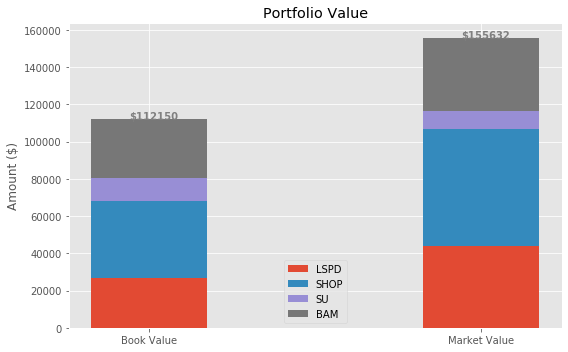

In [6]:
# Plot
labels = ['Book Value', 'Market Value']
width = 0.35
ttl_val = [portf["Book Value"].sum(), portf["Market Value"].sum()]

fig, ax = plt.subplots(figsize =(8, 5))
prev_val = np.zeros(2)

# Plot stacked bar chart
for i in range(len(portf.index)):
    val = [portf["Book Value"].iloc[i], portf["Market Value"].iloc[i]]
    sym = portf["Symbol"].iloc[i]
    ax.bar(labels, val, width, bottom=prev_val, label=sym)
    prev_val += val

# Add total portfolio value at top of bars
for i, v in enumerate(ttl_val):
    ax.text(i-0.06, v+50, '$'+str(round(v)), color='grey', fontweight='bold')    

# Labels
ax.set_ylabel('Amount ($)')
ax.set_title('Portfolio Value')
ax.legend(loc='lower center')
fig.tight_layout()
plt.show()

## Portfolio Distribution

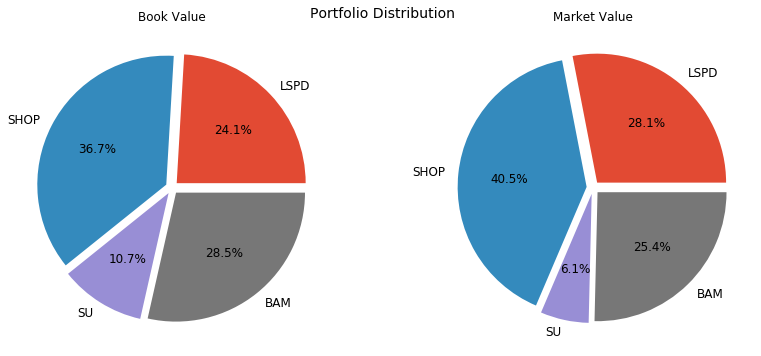

In [7]:
# Formatting 
style_dict={'fontsize': 12}
sym = portf["Symbol"]
n = len(sym)

# Creating plot
fig = plt.figure(figsize =(12, 5))

# Plot historical adjusted close price
ax1 = fig.add_subplot(121)
plt.pie(portf["Book Value"], labels=sym, autopct='%0.1f%%', explode=[0.05]*n, textprops=style_dict)
plt.title("Book Value", fontsize=12)

# Plot percentage change
ax2 = fig.add_subplot(122)
plt.pie(portf["Market Value"], labels=sym, autopct='%0.1f%%', explode=[0.05]*n, textprops=style_dict)
plt.title("Market Value", fontsize=12)

# show plot
plt.suptitle('Portfolio Distribution', fontsize=14)
fig.tight_layout()
plt.show()

## Optimization

This section compares the current holdings against the distributions calculated using various portfolio optimization algorithms. 

Note: Much of the code in this section was leveraged from lecture notes, tutorials and assignments completed as part of the MIE1622 course (UofT).

In [8]:
# Get daily prices over last 12 months
end_dt = date.today()
start_dt = end_dt + relativedelta(months=-12)
hist = pdr.DataReader(list(portf["Symbol"]), start=start_dt, end=end_dt, data_source='yahoo')['Adj Close']

# Exclude any assets that have not existed for the entire period
hist_filt = hist.dropna(axis=1)
sym = hist_filt.columns
units = list(portf[portf["Symbol"].isin(sym)]["Units"])

# Get prices as numpy array
prices = hist_filt.values
prices[:10]

array([[ 31.67432976, 767.89001465,  17.00006104],
       [ 31.74341965, 750.        ,  16.90369034],
       [ 31.46601486, 744.42999268,  16.7976799 ],
       [ 31.06971741, 757.79998779,  16.49892807],
       [ 31.4164772 , 758.        ,  16.94224167],
       [ 32.56574249, 779.5       ,  17.61684418],
       [ 34.61657715, 762.02001953,  18.30208015],
       [ 34.19055557, 735.19000244,  18.69086456],
       [ 35.92435455, 727.77001953,  20.62507439],
       [ 37.36093903, 730.66998291,  20.68339348]])

In [9]:
# U.S. Normalized Risk-Free Rate Lowered from 3.0% to 2.5%, Effective June 30, 2020
r_rf = 0.025

# Daily risk-free rate
dly_r_rf = r_rf / 252

# Number of records
Ns = prices.shape[0]

# Compute means and covariances over time period
cur_returns = prices[1:,:] / prices[:Ns-1,:] - 1
cur_returns = cur_returns

# Expected returns
mu = np.mean(cur_returns, axis=0).reshape(cur_returns.shape[1],)
# Covariances
Q = np.cov(cur_returns.astype(float).T)
# Number of assets
n = prices.shape[1]

# Store results
results_df = pd.DataFrame(columns=["Portfolio"]+list(sym))

In [10]:
# Current portfolio
curr_positions = np.array(units)
# Initial value of the portfolio
curr_value = np.dot(prices[0,:], curr_positions)
# Portfolio weights
w_curr = (prices[0,:] * curr_positions) / curr_value
results_df.loc[0] = ["Current Portfolio"] + list(w_curr)
var_curr = np.dot(w_curr, np.dot(Q, w_curr))
ret_curr = np.dot(mu, w_curr)
print("Current portfolio:")
print("    Solution w: ")
print(w_curr)
print("    Variance =", var_curr)
print("    Expected return =", ret_curr)
print("    Standard deviation =", np.sqrt(var_curr))

Current portfolio:
    Solution w: 
[0.00491319 0.95289515 0.04219166]
    Variance = 0.0010834330156646434
    Expected return = 0.0025456348074340642
    Standard deviation = 0.032915543678703585


In [11]:
# Minimum variance portfolio
w1 = cp.Variable(n)
prob1 = cp.Problem(cp.Minimize(cp.quad_form(w1, Q)),
                 [sum(w1) == 1,
                  w1 >= 0])
prob1.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})

# Results
w_minVar = w1.value
results_df.loc[1] = ["Minimum Variance"] + list(w_minVar)
var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
ret_minVar = np.dot(mu, w_minVar)
print("Minimum variance portfolio:")
print("    Solution status =", prob1.status)
print("    Solution value =", prob1.value)
print("    Solution w: ")
print(w_minVar)
print("    Variance =", var_minVar)
print("    Expected return =", ret_minVar)
print("    Standard deviation =", np.sqrt(var_minVar))

Minimum variance portfolio:
    Solution status = optimal
    Solution value = 0.0003174251619237063
    Solution w: 
[0.6340896  0.27016574 0.09574466]
    Variance = 0.0003174251619237062
    Expected return = 0.002129986248233989
    Standard deviation = 0.017816429550381475


In [12]:
# Maximum return portfolio of risky assets under no-short-sales constraint
w2 = cp.Variable(n)
prob2 = cp.Problem(cp.Maximize(mu.T@w2),
                 [sum(w2) == 1,
                  w2 >= 0])
prob2.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})

w_maxRet = w2.value
results_df.loc[2] = ["Maximum Return"] + list(w_maxRet)
var_maxRet = np.dot(w_maxRet, np.dot(Q, w_maxRet))
ret_maxRet = np.dot(mu, w_maxRet)
print("Maximum return portfolio:")
print("    Solution status =", prob2.status)
print("    Solution value =", prob2.value)
print("    Solution w: ")
print(w_maxRet)
print("    Variance =", var_maxRet)
print("    Expected return =", ret_maxRet)
print("    Standard deviation =", np.sqrt(var_maxRet))

Maximum return portfolio:
    Solution status = optimal
    Solution value = 0.002580329431709598
    Solution w: 
[0. 1. 0.]
    Variance = 0.0012067662864387327
    Expected return = 0.002580329431709598
    Standard deviation = 0.034738541800696424


In [13]:
# Efficient frontier of risky assets under no-short-sales constraint
# Target returns
targetRet = np.linspace(ret_minVar,ret_maxRet,50)

# Define optimization problem and compute one portfolio on efficient frontier
w3 = cp.Variable(n)
eps = cp.Parameter()
eps.value = targetRet[0]
prob3 = cp.Problem(cp.Minimize(cp.quad_form(w3, Q)),
                 [mu.T@w3 >= eps,
                  sum(w3) == 1,
                  w3 >= 0])
prob3.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})

# Compute efficient frontier
w_front = []
var_front = []
ret_front = []
for epsilon in targetRet:
    eps.value = epsilon
    prob3.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})
    w_front.append(w3.value)
    var_front.append(np.dot(w3.value, np.dot(Q, w3.value)))
    ret_front.append(np.dot(mu, w3.value))

In [14]:
# Equally-weighted (1/N) portfolio of risky assets
w_eqlWt = np.ones(n)/n
results_df.loc[3] = ["Equally-weighted"] + list(w_eqlWt)
var_eqlWt = np.dot(w_eqlWt, np.dot(Q, w_eqlWt))
ret_eqlWt = np.dot(mu, w_eqlWt)
print("Equally-weighted portfolio:")
print("    Solution w: ")
print(w_eqlWt)
print("    Variance =", var_eqlWt)
print("    Expected return =", ret_eqlWt)
print("    Standard deviation =", np.sqrt(var_eqlWt))

Equally-weighted portfolio:
    Solution w: 
[0.33333333 0.33333333 0.33333333]
    Variance = 0.0003584881932670235
    Expected return = 0.0021305337173081937
    Standard deviation = 0.01893378444123159


In [15]:
# Maximum Sharpe ratio portfolio under no-short-sales constraint
w4 = cp.Variable(n)
prob4 = cp.Problem(cp.Minimize(cp.quad_form(w4, Q)),
                 [((mu - dly_r_rf).T@w4) == 1,
                  w4 >= 0])
prob4.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})

# Calculate w = w4/k where k=sum(w4)
w_maxShp = w4.value/sum(w4.value)
results_df.loc[4] = ["Maximum Sharpe Ratio"] + list(w_maxShp)
var_maxShp = np.dot(w_maxShp, np.dot(Q, w_maxShp))
ret_maxShp = np.dot(mu, w_maxShp)
print("Maximum Sharpe Ratio portfolio:")
print("    Solution status =", prob4.status)
print("    Solution value =", prob4.value)
print("    Solution w: ")
print(w_maxShp)
print("    Variance =", var_maxShp)
print("    Expected return =", ret_maxShp)
print("    Standard deviation =", np.sqrt(var_maxShp))

Maximum Sharpe Ratio portfolio:
    Solution status = optimal
    Solution value = 75.612857433571
    Solution w: 
[0.59931102 0.32576512 0.07492386]
    Variance = 0.0003231181376449576
    Expected return = 0.002166408000656843
    Standard deviation = 0.017975487132341022


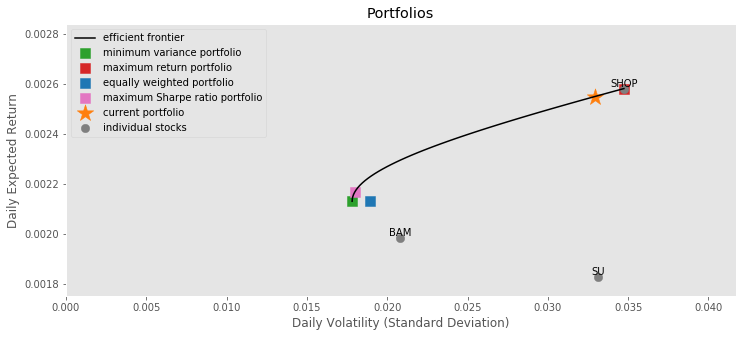

In [18]:
# Plot all portfolios
ax = plt.gca()
plt.rcParams['figure.figsize'] = [12, 5]

# Plot minimum variance portfolio
ax.scatter(x=np.sqrt(var_minVar), y=ret_minVar, marker='s', s=100,  color='tab:green', 
           label='minimum variance portfolio')

# Plot maximum return portfolio
ax.scatter(x=np.sqrt(var_maxRet), y=ret_maxRet,  marker='s', s=100, color='tab:red', 
           label='maximum return portfolio')

# Plot efficient frontier
ax.plot(np.sqrt(var_front), ret_front, '-', color='black', label='efficient frontier')

# Plot equally weighted portfolio
ax.scatter(x=np.sqrt(var_eqlWt), y=ret_eqlWt,  marker='s', s=100, color='tab:blue', 
           label='equally weighted portfolio')

# Plot maximum Sharpe portfolio
ax.scatter(x=np.sqrt(var_maxShp), y=ret_maxShp,  marker='s', s=100, color='tab:pink', 
           label='maximum Sharpe ratio portfolio')

# Plot current portfolio
ax.scatter(x=np.sqrt(var_curr), y=ret_curr,  marker='*', s=300, color='tab:orange', 
           label='current portfolio')

# Plot volatility versus expected return for individual stocks
x_ind = np.sqrt(np.diag(Q))
ax.scatter(x=x_ind, y=mu, s=70, color='tab:grey', label='individual stocks')
for i in range(len(x_ind)):
    ax.annotate(sym[i], (x_ind[i], mu[i]), ha='center', va='bottom')

# Format and display the final plot
ax.axis([0, 1.2*np.max(np.sqrt(np.diag(Q))), np.min(mu)-0.1*(np.max(mu)-np.min(mu)), 1.1*ret_maxRet])
ax.set_xlabel('Daily Volatility (Standard Deviation)')
ax.set_ylabel('Daily Expected Return')
plt.title('Portfolios')
ax.legend(loc="upper left")
ax.grid()
fig.tight_layout()
plt.show()

Total book value: $112,150.00
Total market value: $155,631.50


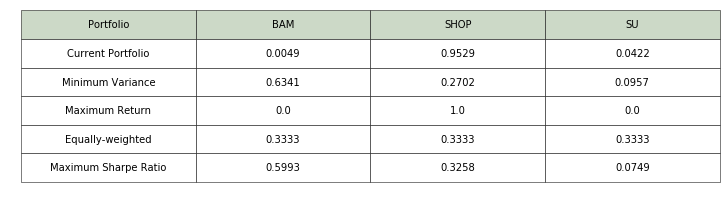

In [17]:
print('Total book value: ${:,.2f}'.format(portf["Book Value"].sum()))
print('Total market value: ${:,.2f}'.format(portf["Market Value"].sum()))

# Round values
results_df = results_df.round(4)

# Plot pretty table
fig, ax = plt.subplots(figsize=(10,3))
table = ax.table(
    cellText=results_df.values, 
    colLabels=results_df.columns, 
    colColours=np.full(len(results_df.columns), "#CCD9C7"),
    cellLoc ='center', 
    loc ='upper left')

#hide the axes
plt.axis('off') 

# Scale the table for better margins
table.scale(1, 2)

#display table
fig.tight_layout()
plt.show()

### Discussion

When using the sample portfolio provided, the current portfolio already lies on the efficient frontier. The SHOP units account for more than 95% of the holdings.

If the portfolio were modified to only hold shares of SHOP, then the portfolio allocation would be equivalent to that of the Maximum Return portfolio. Although this would maximize the potential return based on past performance, this portfolio would be riskier since it is less diverse.

The volatility of this portfolio could be reduced by increasing the weights of the other assets. Of course this would also lower the expected return.